# 1.bis. CBoW demo (Full text)

### Imports

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
# CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Step 1. Produce some data based on a given text for training our CBoW model    

In [2]:
def text_to_train(text, context_window):
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        context = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        target = text[i]
        data.append((context, target))
        
    return data

In [3]:
def create_text():
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [5]:
def generate_data(text, context_window):
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'jews', 'but', 'content', 'lives', 'whithering', 'today', 'they', 'god', 'character', 'neither', 'its', 'storms', 'heavy', 'straight', 'he', 'basic', 'urgency', 'faith', 'chains', 'friends', 'so', 'hampshire', 'desolate', 'autumn', 'country', 'insofar', 'guaranteed', 'demand', 'white', 'nothing', 'your', 'gods', 'georgia', 'dream', 'signed', 'have', 'south', 'judged', 'died', 'given', 'tenement', 'fatal', 'hold', 'equality', 'republic', 'say', 'well', 'americans', 'believes', 'you', 'slaves', 'luxury', 'off', 'sweltering', 'flesh', 'ring', 'transform', 'together', 'when', 'live', 'daybreak', 'little', 'which', 'lips', 'determination', 'what', 'later', 'day', 'veterans', 'let', 'back', 'color', 'lodging', 'mountain', 'architects', 'quicksand', 'in', 'highways', 'speed', 'captivity', 'whirlwinds', 'a', 'history', 'by', 'ghettos', 'rest', 'yes', 'will', 'corners', 'be', 'all', 'steam', 'five', 'spiritual', 'children', 'sons', 'constitution', 'sadly', 'hands', 'summer', 'people', 'police'

In [8]:
print(word2index)

{'jews': 0, 'but': 1, 'content': 2, 'lives': 3, 'whithering': 4, 'today': 5, 'they': 6, 'god': 7, 'character': 8, 'neither': 9, 'its': 10, 'storms': 11, 'heavy': 12, 'straight': 13, 'he': 14, 'basic': 15, 'urgency': 16, 'faith': 17, 'chains': 18, 'friends': 19, 'so': 20, 'hampshire': 21, 'desolate': 22, 'autumn': 23, 'country': 24, 'insofar': 25, 'guaranteed': 26, 'demand': 27, 'white': 28, 'nothing': 29, 'your': 30, 'gods': 31, 'georgia': 32, 'dream': 33, 'signed': 34, 'have': 35, 'south': 36, 'judged': 37, 'died': 38, 'given': 39, 'tenement': 40, 'fatal': 41, 'hold': 42, 'equality': 43, 'republic': 44, 'say': 45, 'well': 46, 'americans': 47, 'believes': 48, 'you': 49, 'slaves': 50, 'luxury': 51, 'off': 52, 'sweltering': 53, 'flesh': 54, 'ring': 55, 'transform': 56, 'together': 57, 'when': 58, 'live': 59, 'daybreak': 60, 'little': 61, 'which': 62, 'lips': 63, 'determination': 64, 'what': 65, 'later': 66, 'day': 67, 'veterans': 68, 'let': 69, 'back': 70, 'color': 71, 'lodging': 72, 'mo

In [9]:
print(index2word)

{0: 'jews', 1: 'but', 2: 'content', 3: 'lives', 4: 'whithering', 5: 'today', 6: 'they', 7: 'god', 8: 'character', 9: 'neither', 10: 'its', 11: 'storms', 12: 'heavy', 13: 'straight', 14: 'he', 15: 'basic', 16: 'urgency', 17: 'faith', 18: 'chains', 19: 'friends', 20: 'so', 21: 'hampshire', 22: 'desolate', 23: 'autumn', 24: 'country', 25: 'insofar', 26: 'guaranteed', 27: 'demand', 28: 'white', 29: 'nothing', 30: 'your', 31: 'gods', 32: 'georgia', 33: 'dream', 34: 'signed', 35: 'have', 36: 'south', 37: 'judged', 38: 'died', 39: 'given', 40: 'tenement', 41: 'fatal', 42: 'hold', 43: 'equality', 44: 'republic', 45: 'say', 46: 'well', 47: 'americans', 48: 'believes', 49: 'you', 50: 'slaves', 51: 'luxury', 52: 'off', 53: 'sweltering', 54: 'flesh', 55: 'ring', 56: 'transform', 57: 'together', 58: 'when', 59: 'live', 60: 'daybreak', 61: 'little', 62: 'which', 63: 'lips', 64: 'determination', 65: 'what', 66: 'later', 67: 'day', 68: 'veterans', 69: 'let', 70: 'back', 71: 'color', 72: 'lodging', 73:

In [10]:
print(data)

[(['i', 'am', 'to', 'join'], 'happy'), (['am', 'happy', 'join', 'with'], 'to'), (['happy', 'to', 'with', 'you'], 'join'), (['to', 'join', 'you', 'today'], 'with'), (['join', 'with', 'today', 'in'], 'you'), (['with', 'you', 'in', 'what'], 'today'), (['you', 'today', 'what', 'will'], 'in'), (['today', 'in', 'will', 'go'], 'what'), (['in', 'what', 'go', 'down'], 'will'), (['what', 'will', 'down', 'in'], 'go'), (['will', 'go', 'in', 'history'], 'down'), (['go', 'down', 'history', 'as'], 'in'), (['down', 'in', 'as', 'the'], 'history'), (['in', 'history', 'the', 'greatest'], 'as'), (['history', 'as', 'greatest', 'demonstration'], 'the'), (['as', 'the', 'demonstration', 'for'], 'greatest'), (['the', 'greatest', 'for', 'freedom'], 'demonstration'), (['greatest', 'demonstration', 'freedom', 'in'], 'for'), (['demonstration', 'for', 'in', 'the'], 'freedom'), (['for', 'freedom', 'the', 'history'], 'in'), (['freedom', 'in', 'history', 'of'], 'the'), (['in', 'the', 'of', 'our'], 'history'), (['the',

In [11]:
def words_to_tensor(words: list, w2i: dict, dtype = torch.FloatTensor):
    tensor =  dtype([w2i[word] for word in words])
    tensor = tensor.to(device)
    return Variable(tensor)

### Step 2. Create a CBoW model and train

In [12]:
class CBOW(nn.Module):

    def __init__(self, context_size, embedding_size, vocab_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.linear = nn.Linear(embedding_size, vocab_size)

    def forward(self, inputs):
        lookup_embeds = self.embeddings(inputs)
        embeds = lookup_embeds.sum(dim=0)
        out = self.linear(embeds)
        #out = F.log_softmax(out, dim = -1)
        return out

In [13]:
# Create model and pass to CUDA
model = CBOW(context_size = 2, embedding_size = 20, vocab_size = len(vocab))
model = model.to(device)
model.train()

CBOW(
  (embeddings): Embedding(467, 20)
  (linear): Linear(in_features=20, out_features=467, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 20
torch.manual_seed(28)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
def get_prediction(context, model, word2index, index2word):
    
    # Get into eval() mode
    model.eval()
    ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
    
    # Forward pass
    prediction = model(ids)
    # Reshape to cover for absence of minibatches (needed for loss function)
    prediction = torch.reshape(prediction, (1, 467))
    _, index = torch.max(prediction, 1)
    
    return index2word[index.item()]

In [16]:
def check_accuracy(model, data, word2index, index2word):
    
    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)
        if prediction == target:
            correct += 1
            
    return correct/len(data)

In [17]:
losses = []
accuracies = []

for epoch in range(epochs):
    total_loss = 0
    
    for context, target in data:
        
        # Prepare data
        ids = words_to_tensor(context, word2index, dtype = torch.LongTensor)
        target = words_to_tensor([target], word2index, dtype = torch.LongTensor)
        
        # Forward pass
        model.zero_grad()
        output = model(ids)
        # Reshape to cover for absence of minibatches (needed for loss function)
        output = torch.reshape(output, (1, 467))
        loss = loss_func(output, target)
        
        # Backward pass and optim
        loss.backward()
        optimizer.step()
        
        # Loss update
        total_loss += loss.data.item()
    
    # Display
    if epoch % 2 == 0:
        accuracy = check_accuracy(model, data, word2index, index2word)
        print("Accuracy after epoch {} is {}".format(epoch, accuracy))
        accuracies.append(accuracy)
        losses.append(total_loss)

Accuracy after epoch 0 is 0.006405693950177936
Accuracy after epoch 2 is 0.03772241992882562
Accuracy after epoch 4 is 0.09323843416370106
Accuracy after epoch 6 is 0.12099644128113879
Accuracy after epoch 8 is 0.13594306049822064
Accuracy after epoch 10 is 0.15444839857651246
Accuracy after epoch 12 is 0.1701067615658363
Accuracy after epoch 14 is 0.1822064056939502
Accuracy after epoch 16 is 0.19430604982206406
Accuracy after epoch 18 is 0.200711743772242


### 3. Visualization

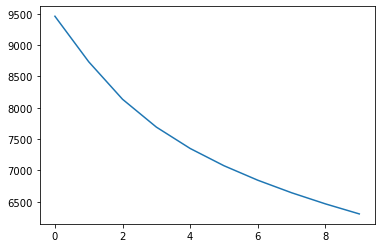

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

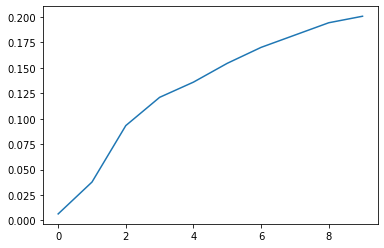

In [19]:
# Display accuracy over time
plt.figure()
plt.plot(accuracies)
plt.show()

In [20]:
word1 = words_to_tensor(["boys"], word2index, dtype = torch.LongTensor)
word2 = words_to_tensor(["brothers"], word2index, dtype = torch.LongTensor)
word3 = words_to_tensor(["dignity"], word2index, dtype = torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
print(w1)
print(w2)
print(w3)

# Boys and Brothers have a somewhat close semantic meaning (strong positive value)
print(torch.dot(w1, w2).item())
# Boys and Dignity do not have a close semantic meaning (strong neg value)
print(torch.dot(w1, w3).item())

tensor([-0.1606,  1.4879,  0.2518, -0.8852, -0.0306,  0.4851,  0.2594, -0.1860,
        -2.2011, -2.3481, -1.3725, -0.8782, -0.3591,  0.1060,  0.9962,  0.0799,
        -0.2924, -0.0751, -0.6925,  0.7900], grad_fn=<ViewBackward>)
tensor([-0.1293, -1.3970,  0.9465,  0.7463, -0.2349, -0.7377,  1.3485,  0.4813,
        -1.3423,  0.3194,  0.8191,  0.1000, -0.1867,  0.3896,  0.0685, -0.9556,
        -0.4420, -0.7653,  0.6932,  0.7392], grad_fn=<ViewBackward>)
tensor([ 0.8420,  0.6778, -0.7475, -0.0075,  1.3125, -0.5583, -1.8175,  0.8931,
        -0.5145, -0.4478, -1.7290,  0.1917,  1.0597, -0.6759, -1.4970, -0.0613,
        -1.7375, -0.5458,  1.6993,  2.2590], grad_fn=<ViewBackward>)
-1.1872433423995972
3.33994197845459


In [21]:
if __name__ == "__main__":
    get_ipython().system('jupyter nbconvert --to script cbow.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook cbow.ipynb to script
[NbConvertApp] Writing 5862 bytes to cbow.py
